# Self study 4

In this self study we investigate some community detection (graph clustering) techniques.  We make extensive use of the Networkx package. The documentation can be found here: https://networkx.org/documentation/stable/reference/index.html

In [1]:
import numpy as np
import networkx as nx
import scipy as sp
import sklearn as skl
import matplotlib.pyplot as plt



from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community.quality import modularity

from sklearn.mixture import GaussianMixture

We are using a social network consisting of 71 lawyers. A description of the network and the original data can be found here:

https://www.stats.ox.ac.uk/~snijders/siena/Lazega_lawyers_data.htm

Of the three different relationships included in the data we will only be using the 'friendship' relation. This is a directed relationship, i.e., friends(a,b) does not necessarily imply friends(b,a) according to the data.

We load a version of the Lazega network data that only contains the 'friends' edges:

In [2]:
lazega=nx.readwrite.graphml.read_graphml('lazega.gml')

The nodes in the graph have the attributes "Practice" "Age" "Seniority" "Office" "Gender" "Status" . To obtain a dictionary with the values for a specified attribute for all nodes, we can use:

In [3]:
nx.get_node_attributes(lazega,'Office')

{'1': 1,
 '2': 1,
 '4': 1,
 '8': 1,
 '17': 1,
 '16': 1,
 '22': 1,
 '26': 1,
 '3': 2,
 '9': 1,
 '11': 1,
 '12': 1,
 '14': 2,
 '19': 1,
 '21': 1,
 '23': 1,
 '27': 1,
 '29': 1,
 '5': 2,
 '7': 2,
 '18': 2,
 '25': 2,
 '24': 1,
 '10': 1,
 '13': 1,
 '34': 1,
 '38': 1,
 '15': 3,
 '20': 1,
 '41': 1,
 '43': 1,
 '52': 1,
 '6': 2,
 '28': 2,
 '50': 2,
 '37': 3,
 '32': 2,
 '39': 1,
 '40': 1,
 '31': 2,
 '33': 2,
 '35': 2,
 '51': 2,
 '58': 2,
 '46': 2,
 '60': 1,
 '36': 1,
 '57': 1,
 '30': 2,
 '42': 1,
 '54': 1,
 '56': 1,
 '48': 1,
 '49': 1,
 '64': 1,
 '45': 1,
 '55': 1,
 '65': 1,
 '62': 1,
 '59': 2,
 '53': 1,
 '61': 1,
 '63': 2,
 '66': 1,
 '69': 1,
 '70': 1,
 '71': 1,
 '68': 1,
 '67': 1}

The following is a little helper function that returns an array of attribute values of nodes according to the order in which nodes are returned by the G.nodes() function

In [4]:
def get_att_array(G,att_name):
    ret_array=np.zeros(nx.number_of_nodes(G))
    for i,n in enumerate(G.nodes()):
        ret_array[i]=G.nodes[n][att_name]
    return(ret_array)

We can use this to plot the graph using one of the layout algorithms provided by networkx, and nodes colored according to one of the attributes:

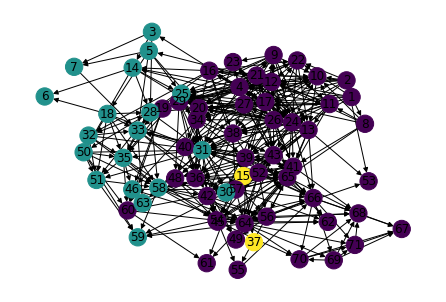

In [5]:
nx.draw_kamada_kawai(lazega,with_labels=True,node_color=get_att_array(lazega,'Office'))

To make things a bit simpler, we turn the directed graph into an undirected one:

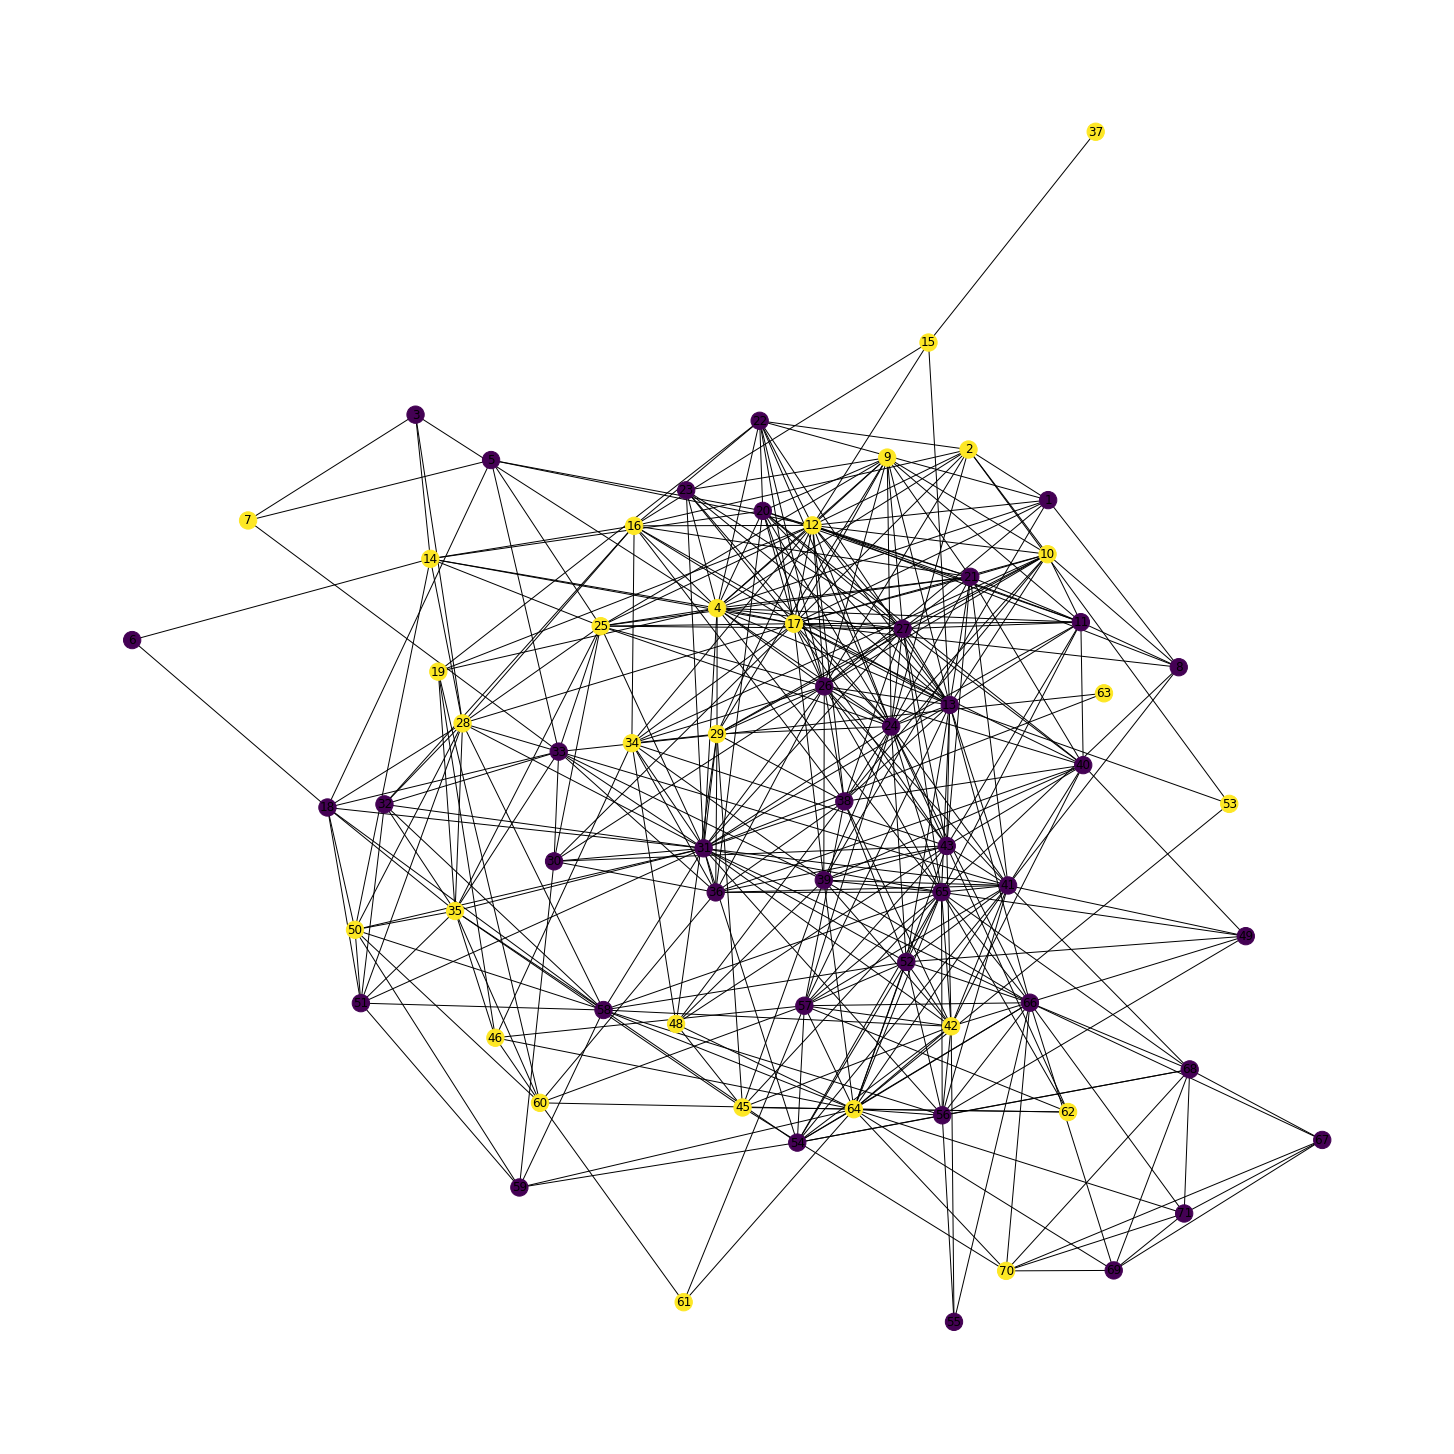

In [6]:
plt.figure(figsize=(20,20))
lazega=lazega.to_undirected()
nx.draw_kamada_kawai(lazega,with_labels=True,node_color=get_att_array(lazega,'Practice'))

The networkx.algorithms.community.quality.modularity function can be used to measure the similarity score of a graph clustering. The clusters (communities) have to be provided as a list of lists of nodes. The following code provides the necessary transformations:

In [7]:
attribute = 'Office'
att_array = get_att_array(lazega,attribute)
att_dict= nx.get_node_attributes(lazega,attribute)
att_communities = []
for c in np.unique(att_array):
    comm_c =[]
    for n in lazega.nodes():
        if att_dict[n]==c:
            comm_c.append(n)
    att_communities.append(comm_c)
    
print("Modularity score of the communities defined by attribute ''{}'': {}".format(attribute,modularity(lazega,att_communities)))    

Modularity score of the communities defined by attribute ''Office'': 0.19672929190143276


**Task 1:** Use the networkx implementations of the Newman-Girvan algorithm to divide the Lazega network into 2,3,4,5 communities. Compare the communities returned by the algorithms with the communities defined by the attributes:
    
To what extend do the detected communities recover the attribute-defined communities? This is a case of what is called supervised cluster evaluation: a class label (or attribute) not used in the clustering process is assumed to represent a true underlying clustering, and we want our clustering method to recreate these underlying "ground truth" clusterings as much as possible (even though we cannot be sure that these "ground truth clusters" are indeed the most relevant clusters -- especially here, where we have multiple attributes that define competing "ground truths").
        
Compare the different community structures (attribute-based, and Newman-Girvan) according to their modularity scores.        
    
    

We now move on to the model-based community detection method. A "cheap" way to obtain embeddings of the nodes into 2-dimensional space is to use a graph layout algorithm. Networkx provides a few layout algorithms that return a dictionary of nodes:coordinates :

In [ ]:
embedding=nx.kamada_kawai_layout(lazega)

**Task 2:** Calculate the log-likelihood of the lazega graph based on embeddings provided by different layout algorithms (cf. slide 31). Which layout provides the best "explanation" for the observed edges based on our probabilistic model?

Given coordinates for the nodes, we can now fit a Gaussian mixture model to these points. First we need to reshape our data again a little bit to fit the requirements of the next method in our pipeline: we turn the dictionary of positions into a standard array, where the first column contains the node identifier (not really needed in the following, but good to have it for possible checks along the road):

In [ ]:
pos_array=np.zeros((len(embedding),3))

for i,k in enumerate(embedding.keys()):
    pos_array[i,0]=int(k)
    pos_array[i,1:3]=embedding[k]
    

We use the sklearn.mixture.GaussianMixture class. Apart from specifying the number of mixture components, we can also restrict the covariance matrices in different ways. For example, covariance_type='tied' means that in the learned model all components have the same covariance matrix (which is the same restriction that we saw in the LDA classification model). 

In [ ]:
gmm=GaussianMixture(n_components=2,covariance_type='tied').fit(pos_array[:,1:3])

Since we are doing clustering, we are using the 'predict' function of the learned mixture models on the training points:

In [ ]:
clusters=gmm.predict(pos_array[:,1:3])

nx.draw(lazega,pos=embedding,with_labels=True,node_color=clusters)

**Task 3:** Compare the modularity scores obtained by Gaussian mixture models with n_components = 2,3,4,5 and embeddings obtained from different layout methods. How does the modularity score relate to the likelihood scores computed in Task 2 -- do embeddings with higher likelihood score lead to clusterings with higher modularity? 

Using coordinates calculated by layout algorithms for our graph mixture model is of course not what one is supposed to do. The "proper" approach is to learn vectors z_i by maximizing the log-likelihood function. A full implementation of such an approach is outside the scope of what we can do in this self study. However, with relatively little effort we can take some steps in this direction. 

We make use of the fact that we already have a very special vector representation of the nodes in form of the rows of the adjacency matrix, which we can access as follows:


In [ ]:
am=nx.adjacency_matrix(lazega)
idx=35
print("The adjacency vector for node {} in a sparse vector representation is \n{}".format(list(lazega.nodes)[idx],am[idx,:]))
print("The same in a standard dense vector representation: \n{}".format(am[idx,:].todense()))

**Beware:** the indices of nodes in our current matrices do not coincide with the node labels we see e.g.  when plotting the graphs. 

Using the dense vector representations, we can use the np.linalg.norm function to compute the Euclidean distance between two adjacency vectors:

In [ ]:
idx0=0
idx1=3
print("The distance between the adjacency vectors of nodes {} and {} is {}".format(list(lazega.nodes)[idx0],\
                                                                              list(lazega.nodes)[idx1],\
                                                                                  np.linalg.norm(am[idx0,:].todense()-am[idx1,:].todense())))

**Task 4:** Construct the 69x69 distance matrix between the nodes of the lazega graph based on the Euclidean distance between the adjacency vectors. Use this matrix and the multidimensional scaling implementation sklearn.manifold.MDS to construct 2-dimensional vector representations for the nodes. Fit again a Gaussian mixture model to these new representations, and compare the modularity score you get now to what you got in the earlier tasks. With this approach we are not limited to 2-dimensional vector representations: how do things change when you use multidimensional scaling with a target dimension of 3 or 4 instead?